<a href="https://colab.research.google.com/github/adindariztia/Bangkit_DiabetesPredictionML/blob/Intan/PIMA_Dataset_Overview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2> Import libraries

In [0]:
%tensorflow_version 2.x

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers

<h2> Read The Dataset

In [0]:
df = pd.read_csv('diabetes.csv')

# Preliminary Exploration with Dataset

First, let's see how many rows and columns in the dataset

In [95]:
df.shape

(768, 9)

Next, see the first rows of the dataset

In [96]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


There are 8 feature columns and 1 outcome. 

It's also good to know the distribution of each columns. So, let's see that by describe function.

In [97]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Since this is a binary-output dataset, let's check whether the output is balanced or not.

In [98]:
print ("{0:.0%}".format(df.Outcome.mean()))

35%


This dataset is not a balanced one.

Create Correlation Matrix to Know Correlating Features

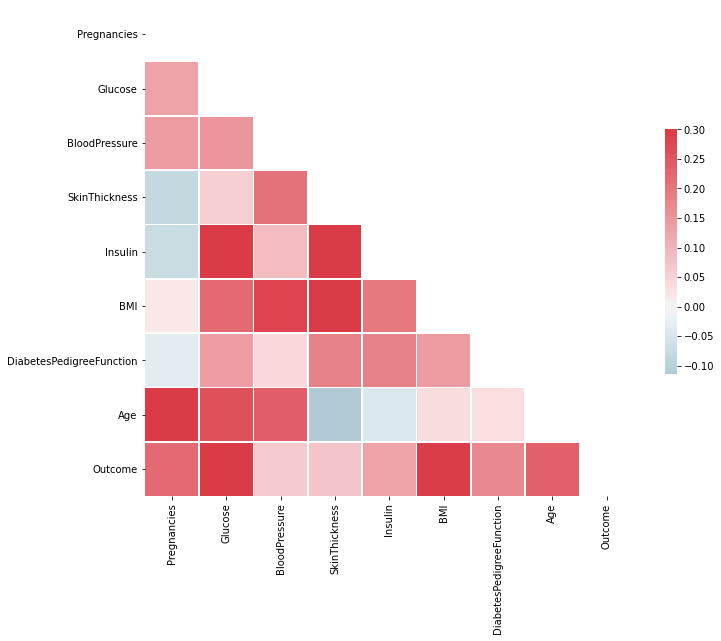

In [99]:
corr = df.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

It looks like there are some missing values replaced by "0" in this dataset. The minimum for some variables does not make sense if it is 0. Let's check the percentage of zeros for each columns.

In [100]:
print("Percentage of Missing Values in each Colume")
for col in df.columns[:-1]:
    print (col + " {0:.0%}".format(df[df[col] == 0].shape[0]/df.shape[0]))

Percentage of Missing Values in each Colume
Pregnancies 14%
Glucose 1%
BloodPressure 5%
SkinThickness 30%
Insulin 49%
BMI 1%
DiabetesPedigreeFunction 0%
Age 0%


Let's substitute the zero values in some columns with median/mean by target.

In [101]:
df_new = df.copy()
cols_to_change = ['BloodPressure', 'BMI', 'Insulin', 'SkinThickness',
                  'Glucose']

for col in cols_to_change:
    mean_0 = np.mean(df.loc[(df.Outcome == 0) & (df[col] != 0) , col])
    median_0 = np.median(df.loc[(df.Outcome == 0) & (df[col] != 0), col])
    print(col, "mean: ", mean_0, "median: ", median_0)
    mean_1 = np.mean(df.loc[(df.Outcome == 1) & (df[col] != 0), col])
    median_1 = np.median(df.loc[(df.Outcome == 1) & (df[col] != 0), col])
    print(col, "mean: ", mean_1, "median: ", median_1)

    if col == 'Insulin':
        df_new.loc[(df_new[col] == 0) & (df_new['Outcome'] == 0), col] = median_0
        df_new.loc[(df_new[col] == 0) & (df_new['Outcome'] == 1), col] = median_1
    else:
        df_new.loc[(df_new[col] == 0) & (df_new['Outcome'] == 0), col] = mean_0
        df_new.loc[(df_new[col] == 0) & (df_new['Outcome'] == 1), col] = mean_1

BloodPressure mean:  70.87733887733887 median:  70.0
BloodPressure mean:  75.32142857142857 median:  74.5
BMI mean:  30.85967413441951 median:  30.1
BMI mean:  35.40676691729318 median:  34.3
Insulin mean:  130.28787878787878 median:  102.5
Insulin mean:  206.84615384615384 median:  169.5
SkinThickness mean:  27.235457063711912 median:  27.0
SkinThickness mean:  33.0 median:  32.0
Glucose mean:  110.64386317907444 median:  107.0
Glucose mean:  142.31954887218046 median:  140.0


In [0]:
# df_new.loc[(df_new.Pregnancies > np.percentile(df_new.Pregnancies, 75)),
#            'Pregnancies'] = np.percentile(df_new.Pregnancies, 75)

In [0]:
# from sklearn.model_selection import KFold

# import tensorflow.contrib.eager as tfe
# tf.enable_eager_execution()

# y = df_new.Outcome
# def make_dataset(X_data,y_data,n_splits):

#     def gen():
#         for train_index, test_index in KFold(n_splits).split(X_data):
#             X_train, X_test = X_data[train_index], X_data[test_index]
#             y_train, y_test = y_data[train_index], y_data[test_index]
#             yield X_train,y_train,X_test,y_test

#     return tf.data.Dataset.from_generator(gen, (tf.float64,tf.float64,tf.float64,tf.float64))

# dataset=make_dataset(df_new, y, 5)

# Creating Models

First, let's separate the dataset into training and test set.

In [0]:
 y = df_new.Outcome #just for the splitting sakes
 X_train, X_test, y_train, y_test = train_test_split(df_new, y, test_size=0.2, 
                                                      random_state=42, 
                                                     shuffle = True)

Let's put the training set into tensorflow frame.



In [0]:
# Create an empty list that will eventually hold all created feature columns.
dataset_columns = df_new.columns
feature_columns = []

# Create numerical feature columns to represent all columns in dataset
for col in dataset_columns[:-1]: 
    #Excluding outcome value, since outcome is still included in dataset
    col_tf = tf.feature_column.numeric_column(col)
    feature_columns.append(col_tf)

# Convert the list of feature columns into a layer that will later be fed into
# the model. 
feature_layer = layers.DenseFeatures(feature_columns)

Next, create the layers and fit the dataset into the model.

In [0]:
def create_model(learningRate, featureLayer, metrics):
  """Construct the model by passing dataset through regression & activation"""
  model = tf.keras.models.Sequential()

  # Add the feature layer that consists the columns/features of the dataset
  model.add(featureLayer)

  # Going through regression and then the sigmoid function for activation
  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                  activation=tf.sigmoid),)

  # Optimise to get the best result, represented by the metrics
  # Use binary cross entropy loss due to binary classification case
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=learningRate),                                                   
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=metrics)

  return model        


def train_model(model, features, label, epochs, label_name,
                batch_size=None, shuffle=True):
  """Feed a dataset into the model in order to train it."""

  # Fit the data into the model
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle, verbose=1)

  return history

Create Plot to visualise the result

In [0]:
def plot_curve(epochs, hist, list_of_metrics):
  """Plot a curve of one or more classification metrics vs. epoch."""  

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()

Now, let's fit the train set into the model. This time, dataset will be split by k-fold, in which there will be k pairs of train and test sets to model and evaluate.

Epoch 1/700
52/52 [==============================] - 0s 2ms/step - loss: 39.4964 - accuracy: 0.3418 - precision: 0.3418 - recall: 1.0000
Epoch 2/700
52/52 [==============================] - 0s 2ms/step - loss: 27.4154 - accuracy: 0.3418 - precision: 0.3418 - recall: 1.0000
Epoch 3/700
52/52 [==============================] - 0s 1ms/step - loss: 14.5350 - accuracy: 0.3418 - precision: 0.3418 - recall: 1.0000
Epoch 4/700
52/52 [==============================] - 0s 2ms/step - loss: 4.1385 - accuracy: 0.4551 - precision: 0.3632 - recall: 0.7886
Epoch 5/700
52/52 [==============================] - 0s 2ms/step - loss: 2.4326 - accuracy: 0.5449 - precision: 0.3657 - recall: 0.4514
Epoch 6/700
52/52 [==============================] - 0s 1ms/step - loss: 2.2666 - accuracy: 0.5527 - precision: 0.3805 - recall: 0.4914
Epoch 7/700
52/52 [==============================] - 0s 2ms/step - loss: 2.1388 - accuracy: 0.5684 - precision: 0.4000 - recall: 0.5257
Epoch 8/700
52/52 [==========================

TypeError: ignored

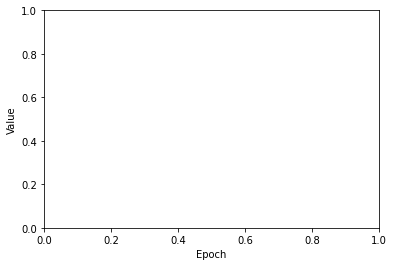

In [108]:
# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 700
batch_size = 10
label_name = "Outcome"
classification_threshold = 0.4

# Establish the metrics the model will measure.
METRICS = [
           tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                           threshold=classification_threshold),
           tf.keras.metrics.Precision(thresholds=classification_threshold,
                                 name='precision' 
                                 ),
           tf.keras.metrics.Recall(thresholds=classification_threshold,
                                 name='recall' 
                                 ),
          ]

# Train the model with K-Fold = 3
kf = KFold(3, random_state=2020, shuffle = True)
batch = 1
for train_idx, val_idx in kf.split(df_new, y):

    # Select the part of dataset to be train set-test set
    # according to indexes from K-Fold
    train_x = df_new.iloc[train_idx]
    train_y = y[train_idx].to_numpy()
    val_x = df_new.iloc[val_idx]
    val_y = y[val_idx].to_numpy()

    # Construct the model
    my_model = create_model(learning_rate, feature_layer, METRICS)

    # Converting train set into numpy formats
    train_features = {name:np.array(value) for name, value in train_x.items()}
    # Remove the label from the features
    train_label = train_y
    # Fit the data into the model
    history = train_model(my_model, train_features, train_label, 
                          epochs, label_name, batch_size)
    
    # Let's see the training result of this batch:
    train_res = my_model.evaluate(x=train_features, y=train_label, batch_size=batch_size)
    print("Train result:")
    print("Batch " + str(batch) +  " accuracy: " + "{:.00%}%".format(train_res[1]))
    print("Batch " + str(batch) +  " precision: " + "{:.00%}%".format(train_res[2]))
    print("Batch " + str(batch) +  " recall: " + "{:.00%}%".format(train_res[3]))
        
    # Let's see how it goes with the test set for this batch:
    test_features = {name:np.array(value) for name, value in val_x.drop(['Outcome'], axis = 1).items()}
    test_label = val_y 
    test_res = my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size)

    print("Test result:")
    print("Batch " + str(batch) +  " accuracy: " + "{:.00%}%".format(test_res[1]))
    print("Batch " + str(batch) +  " precision: " + "{:.00%}%".format(test_res[2]))
    print("Batch " + str(batch) +  " recall: " + "{:.00%}%".format(test_res[3]))
    
    # # The list of epochs is stored separately from the rest of history.
    # epochs = history.epoch

    # # Isolate the classification metric for each epoch.
    # hist = pd.DataFrame(history.history)
    
    # plot_curve(epochs, hist, METRICS)
    batch += 1 

In [0]:
# # The following variables are the hyperparameters.
# learning_rate = 0.001
# epochs = 700
# batch_size = 10
# label_name = "Outcome"
# classification_threshold = 0.4

# # Establish the metrics the model will measure.
# METRICS = [
#            tf.keras.metrics.BinaryAccuracy(name='accuracy', 
#                                            threshold=classification_threshold),
#            tf.keras.metrics.Precision(thresholds=classification_threshold,
#                                  name='precision' 
#                                  ),
#            tf.keras.metrics.Recall(thresholds=classification_threshold,
#                                  name='recall' 
#                                  ),
#           ]

# # Establish the model's topography.
# my_model = create_model(learning_rate, feature_layer, METRICS)

# # Train the model on the training set.
# epochs, hist = train_model(my_model, X_train, epochs, 
#                            label_name, batch_size)

# # Plot a graph of the metric(s) vs. epochs.
# list_of_metrics_to_plot = ['accuracy', 'precision', 'recall'] 

# plot_curve(epochs, hist, list_of_metrics_to_plot)